# Biased SVG estimation

In [1]:
from __future__ import annotations

import datetime
import os.path as osp
import textwrap
from typing import Callable, Optional, Type

import lqsvg.experiment.analysis as analysis
import lqsvg.experiment.utils as eutil
import lqsvg.torch.named as nt
import lqsvg.torch.utils as tutil
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ray
import seaborn as sns
import torch
import torch.nn as nn
from lqsvg.envs import lqr
from lqsvg.envs.lqr.generators import LQGGenerator
from lqsvg.envs.lqr.modules import (
    InitStateDynamics,
    LinearDynamicsModule,
    LQGModule,
    QuadraticReward,
)
from lqsvg.experiment.estimators import DPG, MAAC, AnalyticSVG, MonteCarloSVG
from lqsvg.experiment.plot import default_figsize, plot_surface
from lqsvg.np_util import RNG
from lqsvg.policy.modules import QuadQValue, TVLinearPolicy
from ray.util import ActorPool
from torch import Tensor
from tqdm.auto import tqdm, trange

In [2]:
ray.init()

2021-05-03 17:04:41,214	INFO services.py:1172 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.15.8',
 'raylet_ip_address': '192.168.15.8',
 'redis_address': '192.168.15.8:6379',
 'object_store_address': '/tmp/ray/session_2021-05-03_17-04-40_567278_21491/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-05-03_17-04-40_567278_21491/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-05-03_17-04-40_567278_21491',
 'metrics_export_port': 62478,
 'node_id': 'e62ab7aadf3ba911a7bea6ae4df2012a8e88962ce2aaf952232a25eb'}

## Biased/Unbiased (DPG/MAAC) estimators

In [3]:
class KStepModules(nn.Module):
    def __init__(
        self,
        policy: TVLinearPolicy,
        transition: LinearDynamicsModule,
        reward: QuadraticReward,
        qvalue: QuaQValue,
    ):
        super().__init__()
        self.policy = policy
        self.transition = transition
        self.reward = reward
        self.qvalue = qvalue


class KStepEstimator(nn.Module):
    def __init__(
        self, modules: KStepModules, obs: Tensor, kind: Union[Type[DPG], Type[MAAC]]
    ):
        super().__init__()
        self.nn = modules
        self.state_dataset = obs
        self.kind = kind
        self.estimator = self.kind(
            modules.policy, modules.transition, modules.reward, modules.qvalue
        )
        self.n_steps: int = 0

    def sample_starting_obs(self, samples: int) -> Tensor:
        if samples == self.state_dataset.size("B"):
            return self.state_dataset
        idxs = torch.randint(low=0, high=self.state_dataset.size("B"), size=(samples,))
        return nt.index_select(self.state_dataset, dim="B", index=idxs)

    def surrogate(self, samples: int = 1) -> Tensor:
        obs = self.sample_starting_obs(samples)
        return self.estimator.surrogate(obs, n_steps=self.n_steps)

    def forward(self, samples: int = 1) -> tuple[Tensor, lqr.Linear]:
        obs = self.sample_starting_obs(samples)
        return self.estimator(obs, n_steps=self.n_steps)

    def delta_to_surrogate(
        self, samples: int, n_step: int, update_q: bool = False
    ) -> Callable[[np.ndarray], np.ndarray]:
        K_0, k_0 = self.nn.policy.standard_form()

        @torch.no_grad()
        def f_delta(delta: np.ndarray) -> np.ndarray:
            vector = nt.vector(tutil.as_float_tensor(delta))
            delta_K, delta_k = tutil.vector_to_tensors(vector, (K_0, k_0))
            policy = TVLinearPolicy.from_existing((K_0 + delta_K, k_0 + delta_k))
            if update_q:
                qvalue = QuadQValue.from_policy(
                    policy.standard_form(),
                    self.nn.transition.standard_form(),
                    self.nn.reward.standard_form(),
                )
            else:
                qvalue = self.nn.qvalue
            modules = KStepModules(policy, self.nn.transition, self.nn.reward, qvalue)
            estimator = KStepEstimator(modules, self.state_dataset, self.kind)
            estimator.n_steps = n_step
            surrogate = estimator.surrogate(samples)
            return surrogate.numpy()

        return f_delta

# Trial definition

In [4]:
def make_generator(seed: int) -> LQGGenerator:
    return LQGGenerator(
        n_state=2,
        n_ctrl=2,
        horizon=20,
        stationary=True,
        passive_eigval_range=(0.5, 1.5),
        controllable=True,
        rng=seed,
    )

In [5]:
def make_lqg_module(generator: LQGGenerator) -> LQGModule:
    dynamics, cost, init = generator()
    return LQGModule.from_existing(dynamics, cost, init)

In [6]:
def make_stabilizing_policy(module: LQGModule, rng: RNG) -> TVLinearPolicy:
    policy = TVLinearPolicy(module.n_state, module.n_ctrl, module.horizon)
    policy.stabilize_(module.trans.standard_form(), rng=rng)
    return policy

In [7]:
def grad_estimates(
    estimator,
    sample_sizes: list[int],
    estimates_per_sample_size: int = 10,
    pbar: bool = False,
) -> list[list[lqr.Linear]]:
    progress = tqdm(
        sample_sizes, desc="Computing SVG by sample size", leave=False, disable=not pbar
    )
    svgs_by_sample_size = []
    for size in progress:
        svgs = [estimator(samples=size)[1] for _ in range(estimates_per_sample_size)]
        svgs_by_sample_size += [svgs]
    return svgs_by_sample_size

In [8]:
class Trial:
    def __init__(self, seed: int, total_states: int = 1000):
        self.rng = np.random.default_rng(seed)
        self.generator = make_generator(self.rng)
        self.lqg, self.policy, self.qvalue = self.make_modules(self.generator)

        with tutil.default_generator_seed(seed):
            self.states = self.starting_states(self.policy, self.lqg, total_states)

        modules = KStepModules(
            self.policy, self.lqg.trans, self.lqg.reward, self.qvalue
        )
        self.estimator = {
            "dpg": KStepEstimator(modules, self.states, kind=DPG),
            "maac": KStepEstimator(modules, self.states, kind=MAAC),
        }

    def make_modules(
        self, generator: LQGGenerator
    ) -> tuple[LQGModule, TVLinearPolicy, QuadQValue]:
        with nt.suppress_named_tensor_warning():
            dynamics, cost, init = generator()
        model = LQGModule.from_existing(dynamics, cost, init)
        policy = TVLinearPolicy(model.n_state, model.n_ctrl, model.horizon)
        policy.stabilize_(dynamics, rng=self.rng)
        qvalue = QuadQValue.from_policy(policy.standard_form(), dynamics, cost)
        return model, policy, qvalue

    @staticmethod
    def starting_states(policy: TVLinearPolicy, model: LQGModule, num: int) -> Tensor:
        rollout_module = MonteCarloSVG(policy, model)
        n_trajs = num // model.horizon
        with torch.no_grad():
            obs, _, _, _, _ = rollout_module.rsample_trajectory(torch.Size([n_trajs]))
        obs = obs.flatten(["H", "B1"], "B")
        return obs

# Comparisons

## Gradient quality (bias/variance)

In [9]:
@ray.remote
class GradientQualityTrial(Trial):
    def __init__(self, seed: int, total_states: int):
        super().__init__(seed, total_states)
        _, self.true_svg = AnalyticSVG(self.policy, self.lqg)()

    def gradient_quality_vs_samples(
        self, sample_sizes: np.ndarray, n_step: int, estimates: int
    ) -> pd.DataFrame:
        rows = sum(
            (self.gradient_estimation_data(s, n_step, estimates) for s in sample_sizes),
            start=[],
        )
        columns = [
            "#Samples",
            "Avg. cos sim with true grad",
            "Avg. pairwise cos sim",
            "Norm",
            "Estimator",
        ]
        data = pd.DataFrame(rows, columns=columns)
        data["K"] = n_step
        data["trial"] = self.generator.rng
        return data

    def gradient_estimation_data(
        self, samples: int, n_step: int, estimates: int
    ) -> list:
        rows = []
        for name, estimator in self.estimator.items():
            svgs = self.grad_estimates(estimator, samples, n_step, estimates)
            cossim = analysis.gradient_accuracy(svgs, self.true_svg)
            empvar = analysis.empirical_variance(svgs)
            norm = np.mean([eutil.linear_feedback_norm(s).numpy() for s in svgs])
            rows += [[samples, cossim, empvar, norm, name]]

        return rows

    @staticmethod
    def grad_estimates(
        estimator, samples: int, n_step: int, estimates: int = 10
    ) -> list[lqr.Linear]:
        old = estimator.n_steps
        estimator.n_steps = n_step
        estimates = [estimator(samples)[1] for _ in range(estimates)]
        estimator.n_steps = old
        return estimates


class GradientQualityComparison:
    def __init__(self, seeds: list[int], total_states: int = 1000):
        self.seeds = seeds
        self.total_states = total_states
        self.actors = None
        self.data = None

    def collect(self, sample_sizes: np.ndarray, n_steps: np.ndarray):
        if self.actors is None:
            self.actors = [
                GradientQualityTrial.remote(seed=s, total_states=self.total_states)
                for s in self.seeds
            ]

        remaining = [
            a.gradient_quality_vs_samples.remote(sample_sizes, n_step=k, estimates=10)
            for k in n_steps
            for a in self.actors
        ]
        ready = []
        with tqdm(desc="Collecting", total=len(remaining)) as pbar:
            while remaining:
                done, remaining = ray.wait(remaining)
                ready += done
                pbar.update(len(done))
        self.data = pd.concat(ray.get(ready), ignore_index=True)

    def save(self):
        assert self.data is not None
        now = datetime.datetime.now().isoformat(timespec="minutes")
        path = osp.join("local", f"{type(self).__name__}-{now}.csv")
        self.data.to_csv(path, index=False)

    def load(self, path: str):
        assert self.data is None
        self.data = pd.read_csv(path, index_col=False)
        
    def convert(self):
        assert self.data is not None
        if "K" not in self.data and "K (steps)" in self.data:
            self.data["K"] = self.data["K (steps)"]
        if "SVG estimator" not in self.data and "Estimator" in self.data:
            self.data["SVG estimator"] = self.data["Estimator"]

    def plot_overall(self):
        assert self.data is not None
        sns.set_theme()
        x = "#Samples"
        ys = ["Avg. cos sim with true grad", "Avg. pairwise cos sim", "Norm"]
        hue = "Estimator"
        n_steps = np.sort(self.data["K"].unique())
        n_row = n_steps.size
        n_col = len(ys)

        fig, axes = plt.subplots(
            n_row, n_col, squeeze=False, figsize=default_figsize(n_row, n_col)
        )
        for col in range(n_col):
            axes[0, col].get_shared_y_axes().join(*axes[:, col])
        for row in trange(n_row, desc="Plotting"):
            data = self.data[self.data["K"] == n_steps[row]]
            for ax, y in zip(axes[row], ys):
                sns.lineplot(ax=ax, x=x, y=y, data=data, hue=hue, ci="sd")
            twin = axes[row][-1].twinx()
            twin.set_ylabel(f"K = {n_steps[row]}", rotation=90, labelpad=10)
            twin.get_yaxis().set_ticks([])

        plt.show()
        
    def plot_gradient_acc(self):
        assert self.data is not None
        sns.set_theme()
        sns.relplot(
            kind="line",
            data=self.data,
            x="#Samples",
            y="Avg. cos sim with true grad",
            hue="SVG estimator",
            col="K",
            ci="sd",
        )
        plt.show()
    
    def plot_gradient_var(self):
        assert self.data is not None
        sns.set_theme()
        sns.relplot(
            kind="line",
            data=self.data,
            x="#Samples",
            y="Avg. pairwise cos sim",
            hue="SVG estimator",
            col="K",
            ci="sd",
        )
        plt.show()
        
    def plot_gradient_norm(self, agg: bool = True):
        assert self.data is not None
        sns.set_theme()
        fgrid = sns.relplot(
            kind="scatter",
            data=self.data,
            x="#Samples",
            y="Norm",
            hue="SVG estimator",
            col="K",
            ci="sd",
            estimator="mean" if agg else None,
        )
        fgrid.set(ylim=np.percentile(self.data["Norm"], [2.5, 97.5]))
        plt.show()
        
    def plot_acc_vs_nstep(self):
        data = self.data[self.data["#Samples"] == self.data["#Samples"].max()]
        sns.set_theme()
        sns.relplot(
            kind="scatter",
            data=data,
            x="K",
            y="Avg. cos sim with true grad",
            hue="SVG estimator",
            style="SVG estimator",
        )
        plt.show()

In [10]:
comp = GradientQualityComparison(seeds=np.arange(10), total_states=50000)

In [11]:
comp.collect([comp.total_states], np.arange(1, 21))
# comp.load("local/GradientQualityComparison-2021-05-03T09:47.csv")

Collecting:   0%|          | 0/200 [00:00<?, ?it/s]

2021-05-03 17:04:45,259	WARNING worker.py:1107 -- WARNING: 12 PYTHON workers have been started. This could be a result of using a large number of actors, or it could be a consequence of using nested tasks (see https://github.com/ray-project/ray/issues/3644) for some a discussion of workarounds.


In [12]:
comp.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   #Samples                     400 non-null    int64  
 1   Avg. cos sim with true grad  400 non-null    float64
 2   Avg. pairwise cos sim        400 non-null    float64
 3   Norm                         400 non-null    float64
 4   Estimator                    400 non-null    object 
 5   K                            400 non-null    int64  
 6   trial                        400 non-null    object 
dtypes: float64(3), int64(2), object(2)
memory usage: 22.0+ KB


In [13]:
comp.save()

In [15]:
comp.convert()

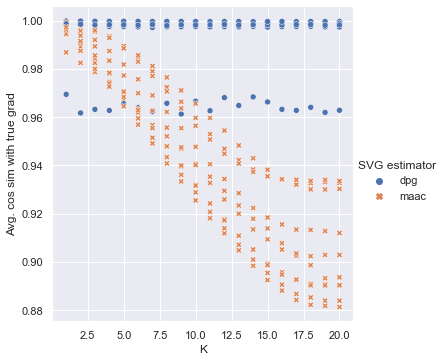

In [16]:
comp.plot_acc_vs_nstep()

In [ ]:
comp.plot_gradient_acc()
comp.plot_gradient_var()
comp.plot_gradient_norm(agg=False)

## Optimization surface

In [22]:
class OptimizationSurfaceComparison(Trial):
    def plot_real_vs_surrogate(
        self, estimator: str, samples: int, n_step: int, seed: Optional[int] = None
    ):
        sns.reset_orig()
        estim = self.estimator[estimator]
        estim.n_steps = n_step

        seed = seed or self.rng.integers(np.iinfo(int).max)
        with tutil.default_generator_seed(seed):
            _, svg = estim(samples)
            direction = tutil.tensors_to_vector(svg).numpy()

            real_XYZ = analysis.optimization_surface(
                self.delta_to_return(),
                direction=direction,
                max_scaling=3.0,
                steps=20,
                rng=seed,
            )
            surrogate_XYZ = analysis.optimization_surface(
                estim.delta_to_surrogate(samples, n_step, update_q=False),
                direction=direction,
                max_scaling=3.0,
                steps=20,
                rng=seed,
            )

        fig = plt.figure(figsize=default_figsize(2, 4))
        ax1 = fig.add_subplot(1, 2, 1, projection="3d")
        ax2 = fig.add_subplot(1, 2, 2, projection="3d")
        plot_surface(*real_XYZ, ax=ax1, invert_xaxis=True)
        plot_surface(*surrogate_XYZ, ax=ax2, invert_xaxis=True)
        ax1.set_xlabel("Random direction")
        ax2.set_xlabel("Random direction")
        ax1.set_ylabel(f"SVG ({estimator}) direction")
        ax2.set_ylabel(f"SVG ({estimator}) direction")
        ax1.set_zlabel("Policy return")
        ax2.set_zlabel("Surrogate value")
        fig.suptitle(f"NStep: {n_step}")
        plt.show()

    def delta_to_return(self) -> Callable[[np.ndarray], np.ndarray]:
        policy = self.policy.standard_form()
        dynamics, cost, init = self.lqg.standard_form()
        return analysis.delta_to_return(policy, dynamics, cost, init)

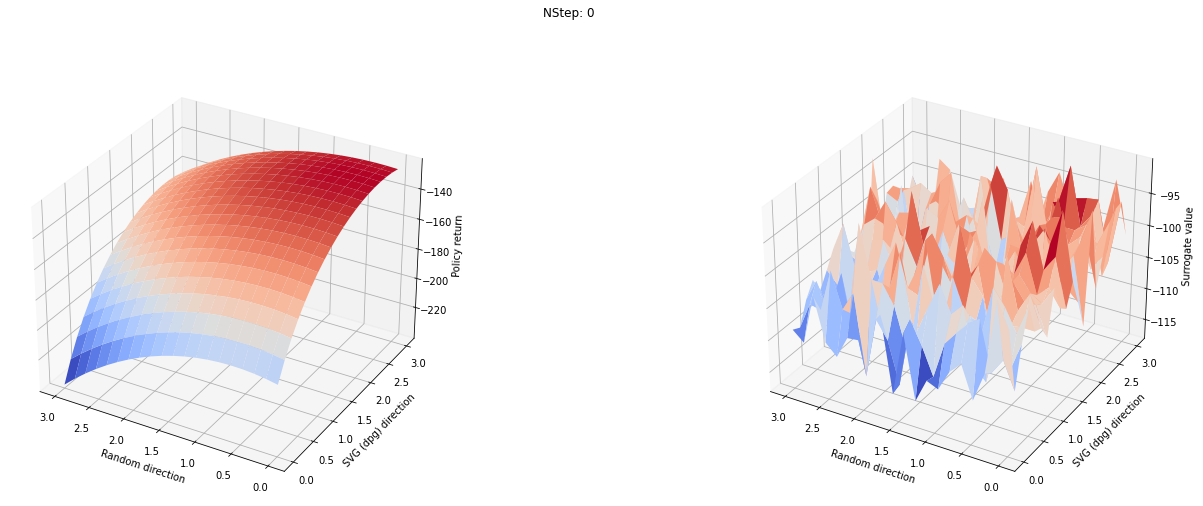

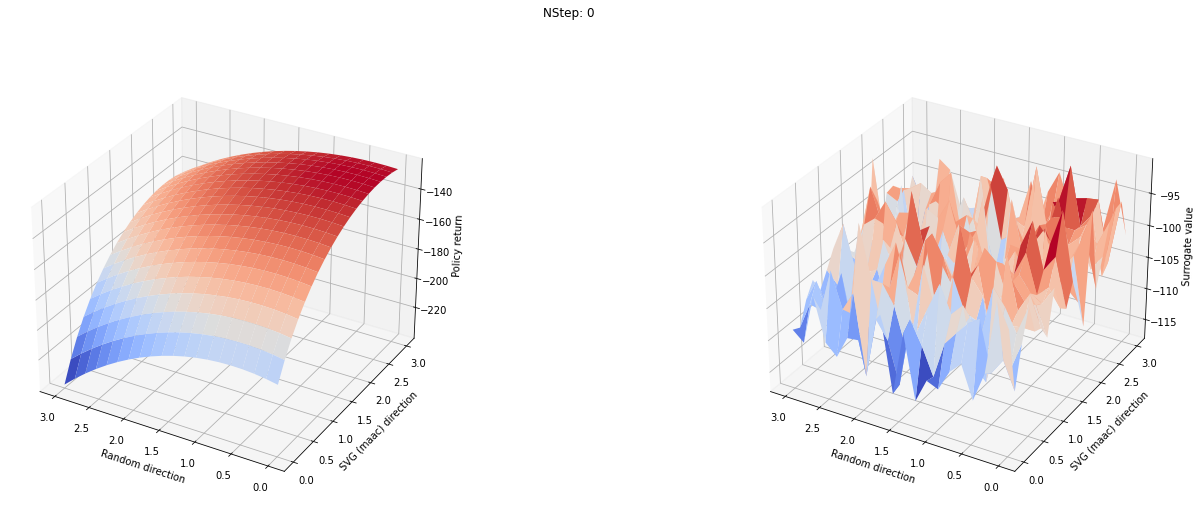

In [23]:
comparator = OptimizationSurfaceComparison(4)
comparator.plot_real_vs_surrogate("dpg", samples=200, n_step=0, seed=4)
comparator.plot_real_vs_surrogate("maac", samples=200, n_step=0, seed=4)

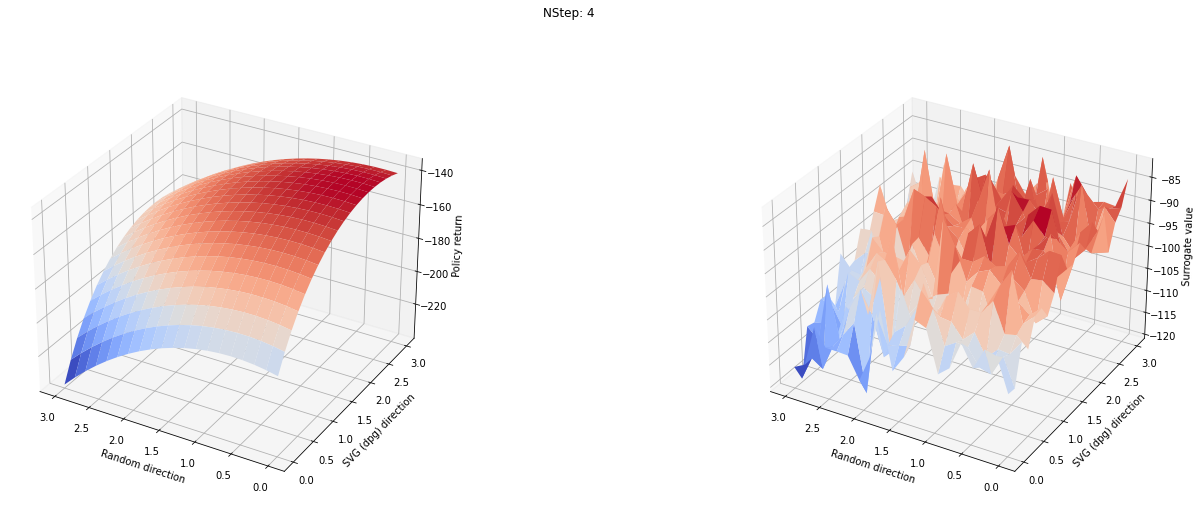

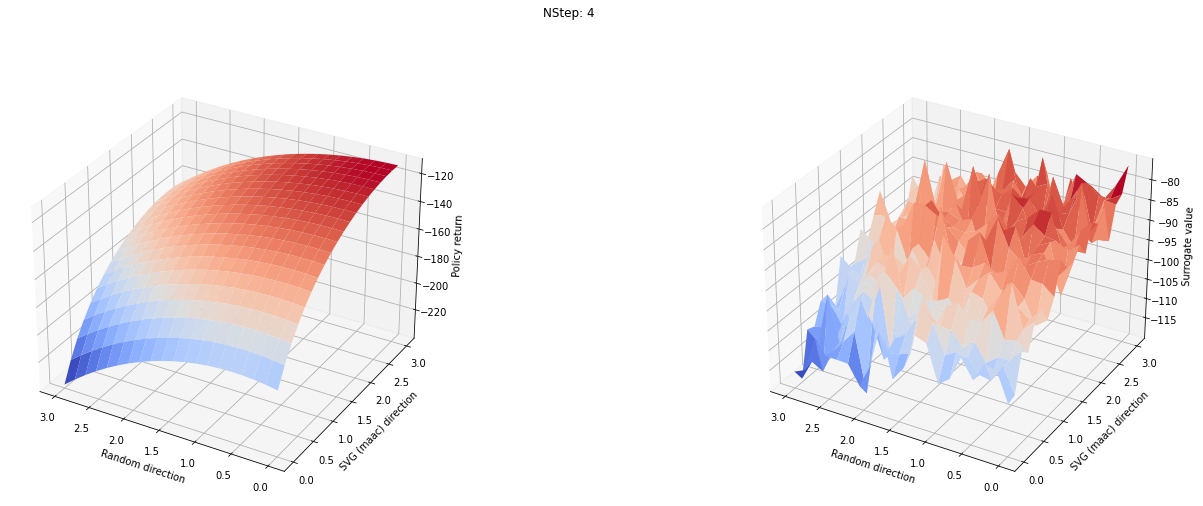

In [24]:
comparator.plot_real_vs_surrogate("dpg", samples=200, n_step=4, seed=4)
comparator.plot_real_vs_surrogate("maac", samples=200, n_step=4, seed=4)

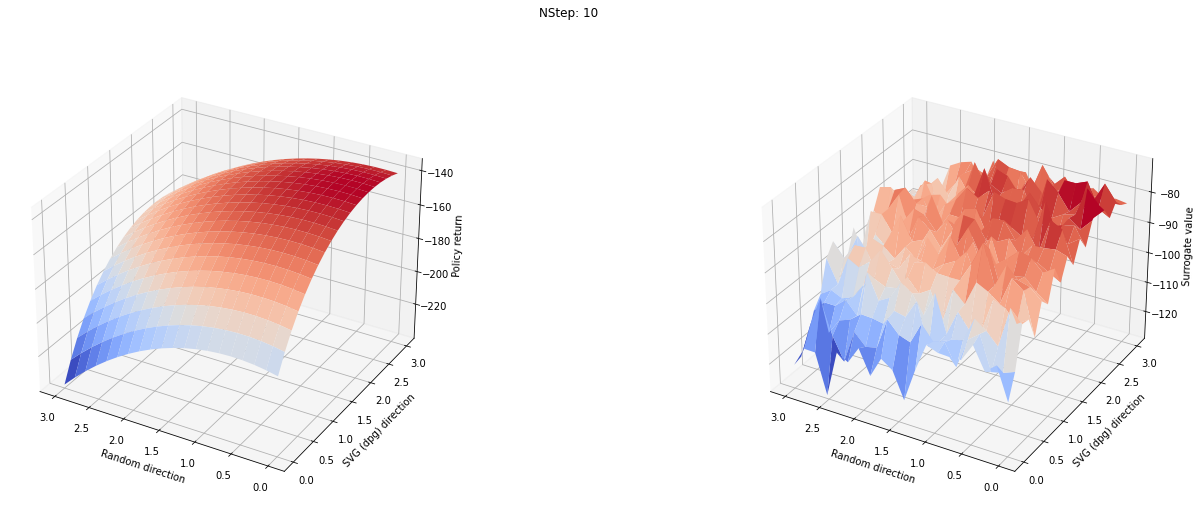

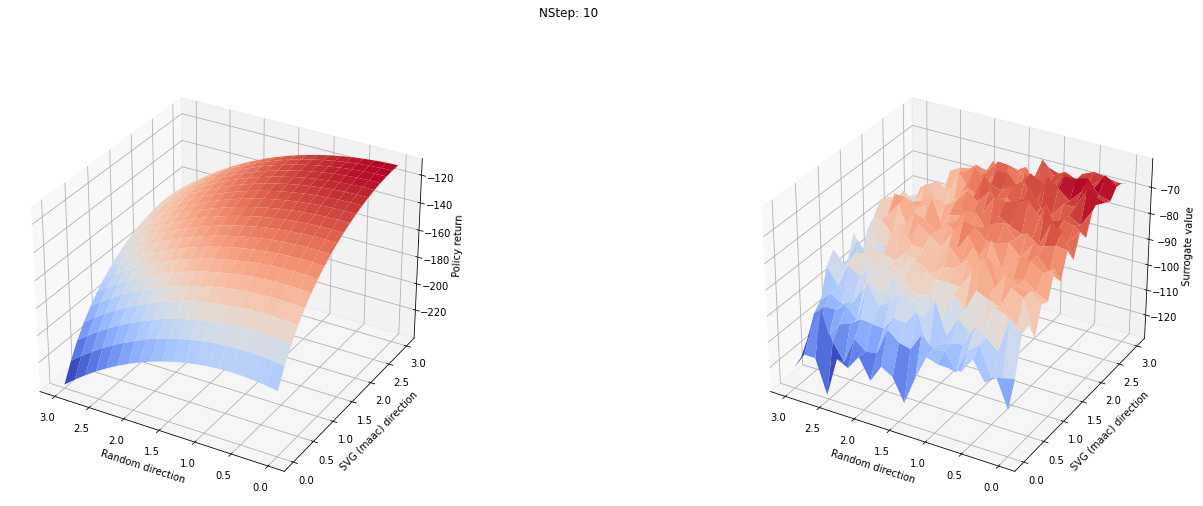

In [25]:
comparator.plot_real_vs_surrogate("dpg", samples=200, n_step=10, seed=4)
comparator.plot_real_vs_surrogate("maac", samples=200, n_step=10, seed=4)

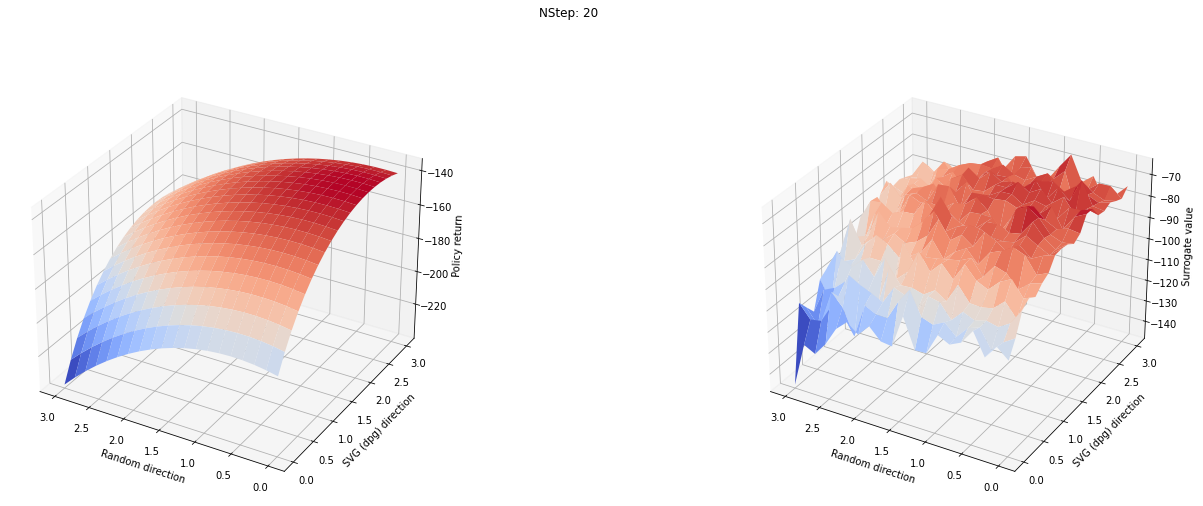

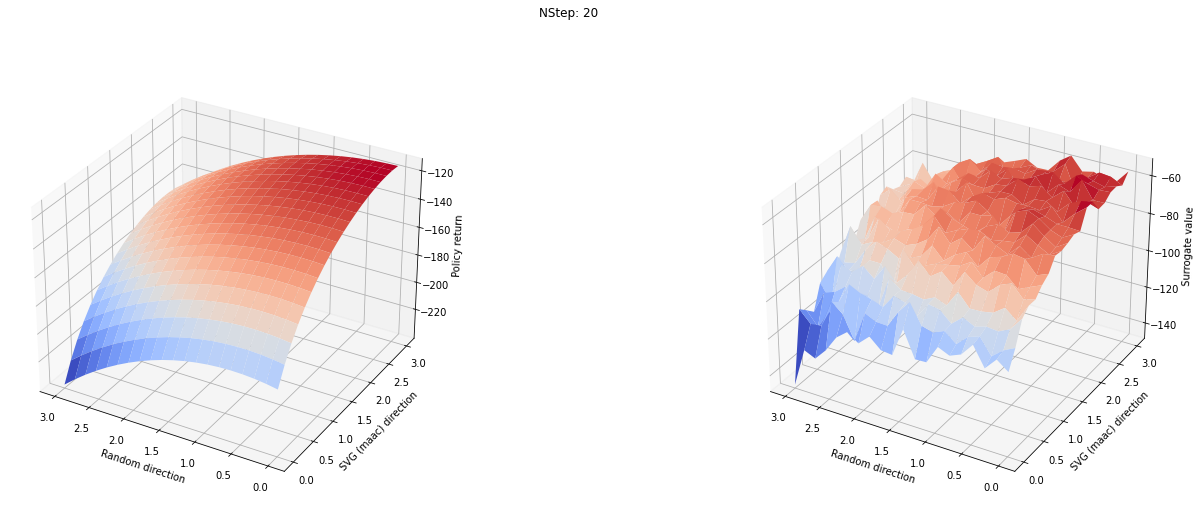

In [26]:
comparator.plot_real_vs_surrogate("dpg", samples=200, n_step=20, seed=4)
comparator.plot_real_vs_surrogate("maac", samples=200, n_step=20, seed=4)

In [27]:
# comparator = OptimizationSurfaceComparison(4)
# comparator.plot_real_vs_surrogate("dpg", samples=200, n_step=0, update_q=True)
# comparator.plot_real_vs_surrogate("maac", samples=200, n_step=0, update_q=True)
# comparator.plot_real_vs_surrogate("dpg", samples=200, n_step=3, update_q=True)
# comparator.plot_real_vs_surrogate("maac", samples=200, n_step=3, update_q=True)

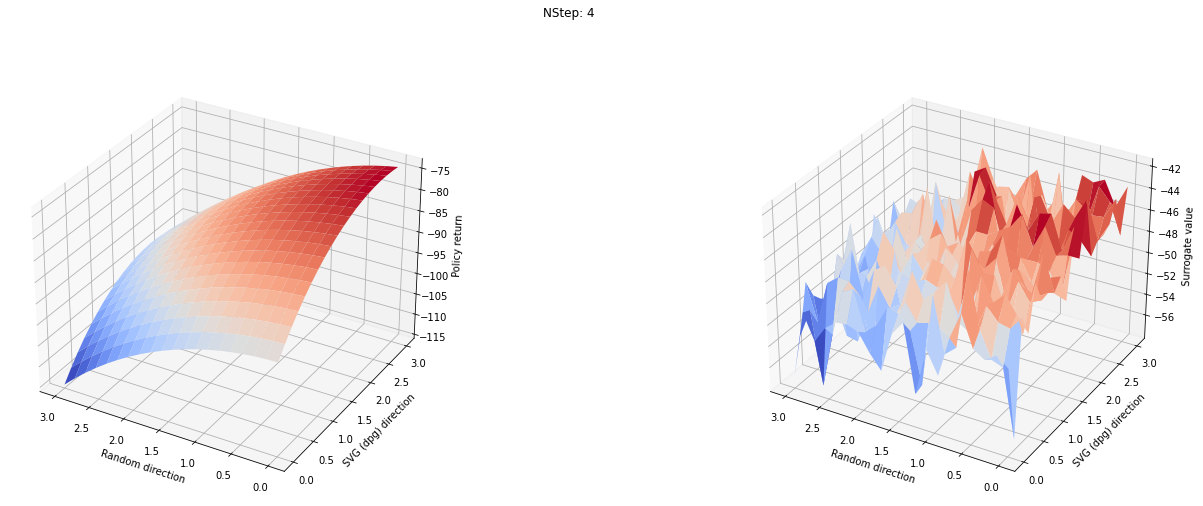

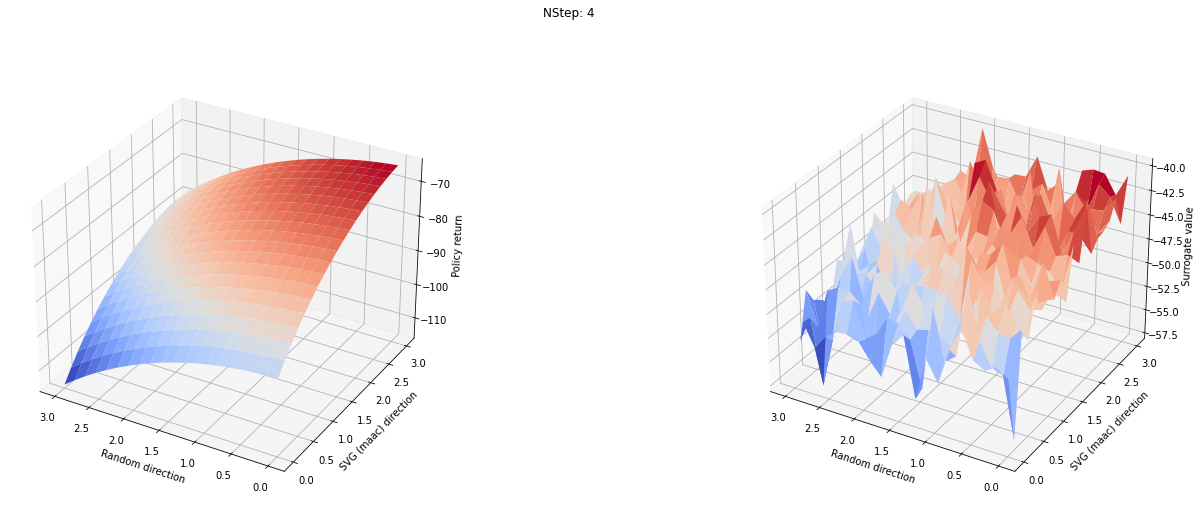

In [28]:
comparator = OptimizationSurfaceComparison(42)
comparator.plot_real_vs_surrogate("dpg", samples=200, n_step=4, seed=42)
comparator.plot_real_vs_surrogate("maac", samples=200, n_step=4, seed=42)

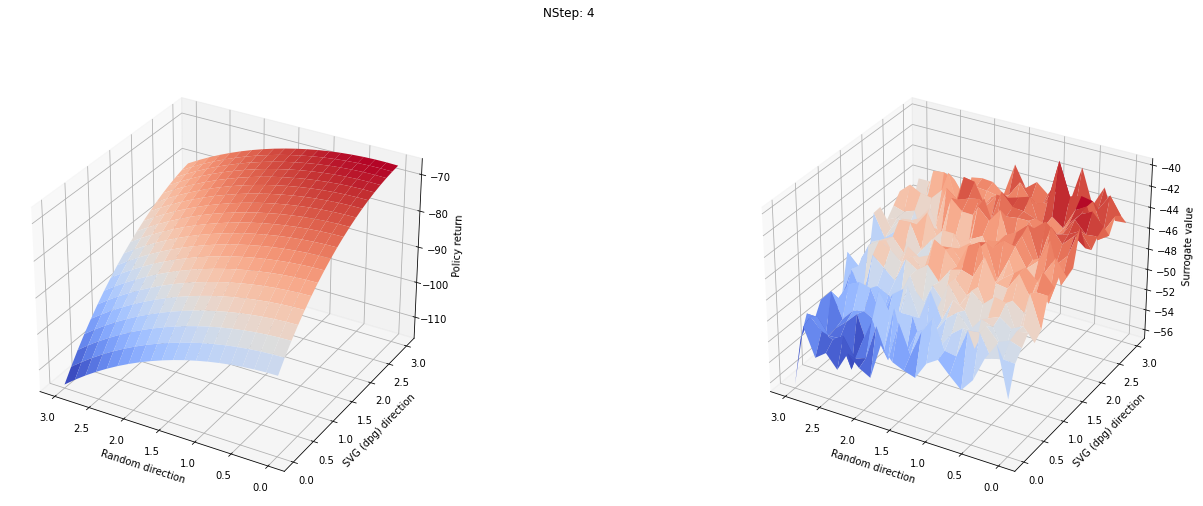

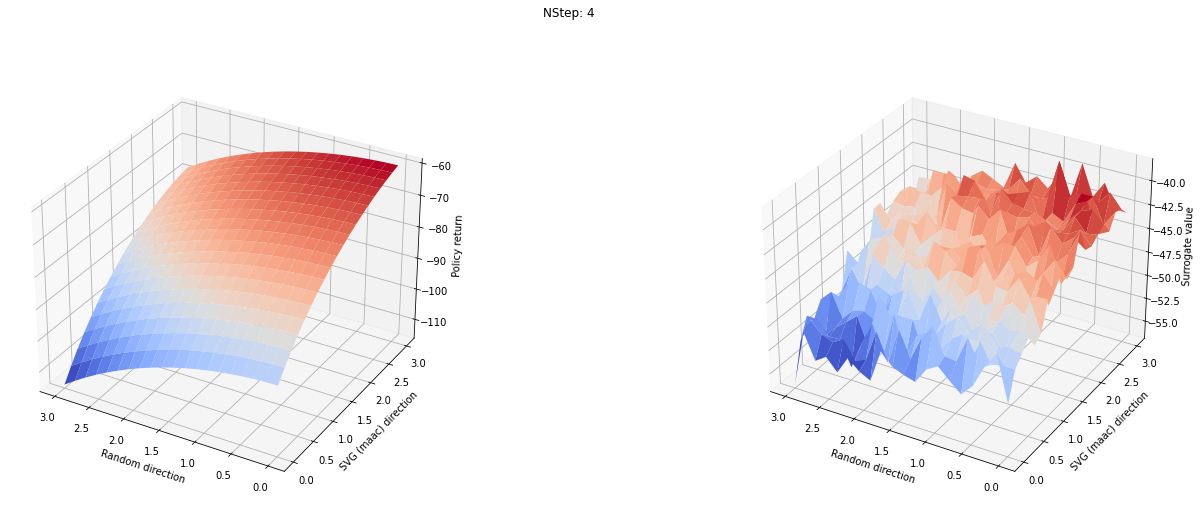

In [29]:
comparator.plot_real_vs_surrogate("dpg", samples=500, n_step=4, seed=42)
comparator.plot_real_vs_surrogate("maac", samples=500, n_step=4, seed=42)